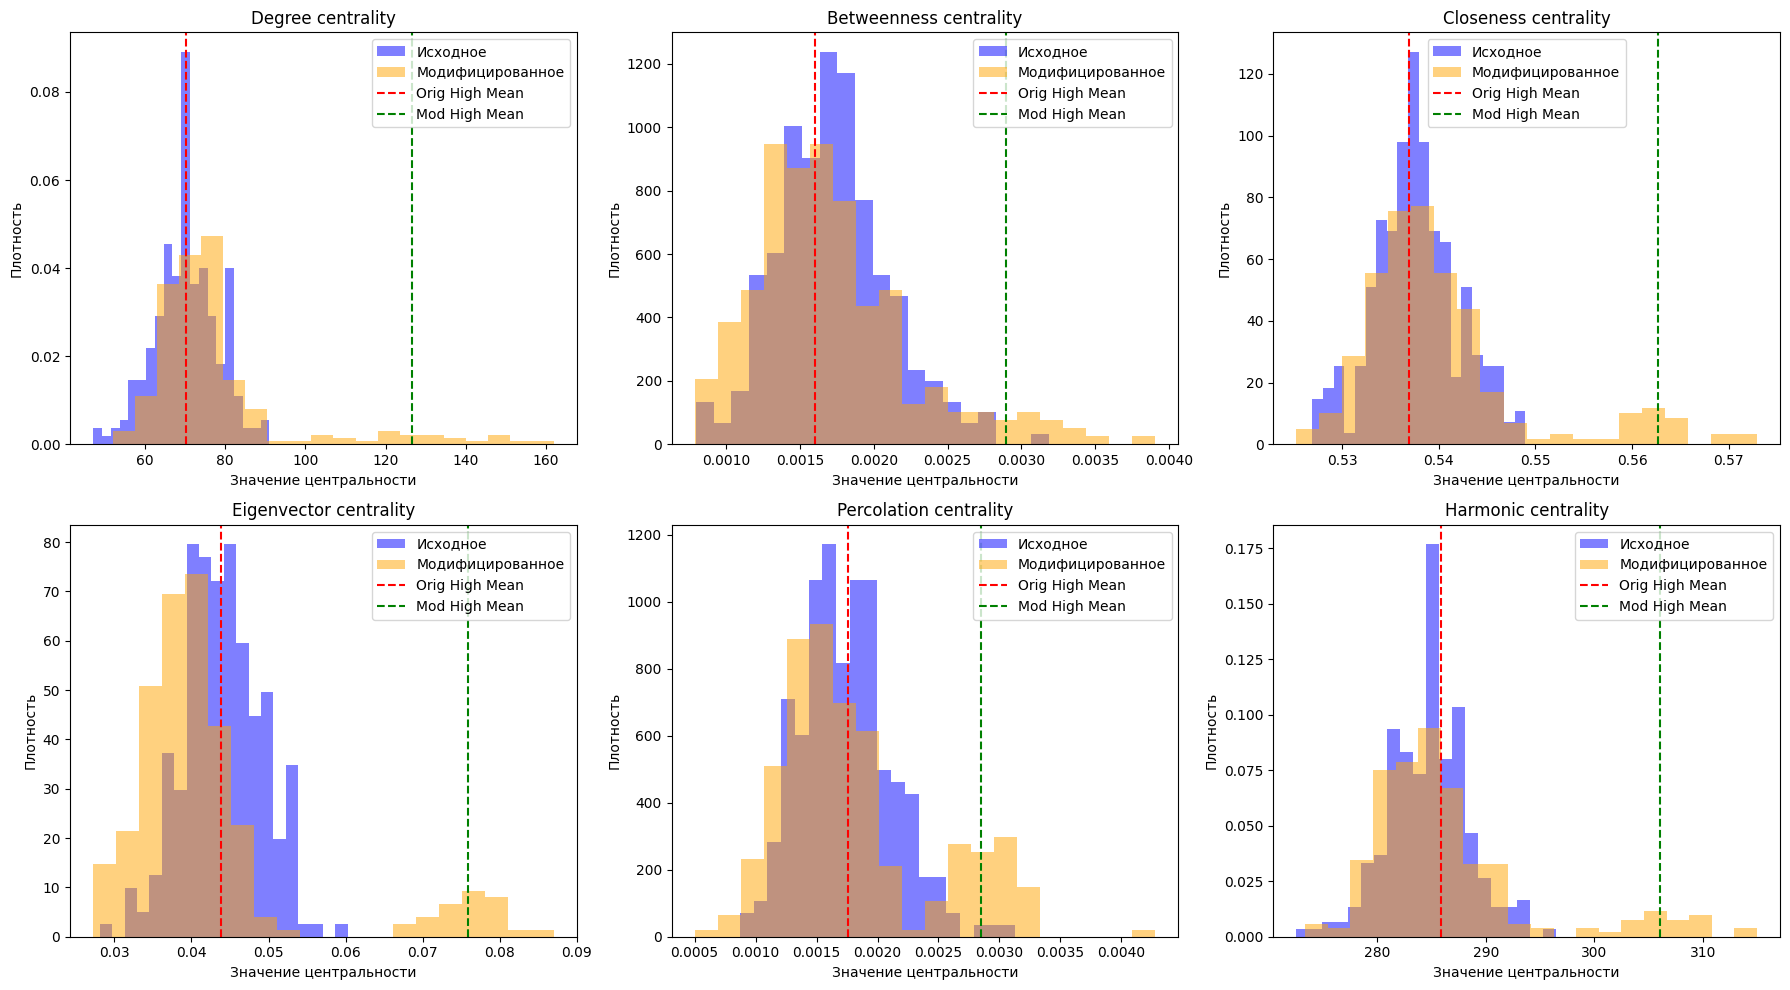

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
from scipy.stats import powerlaw
import matplotlib.pyplot as plt

def generate_sbm_with_high_centrality(
    n, cluster_sizes, p_intra, p_inter,
    target_cluster_index, proportion_high_centrality=0.2,
    centrality_type="degree", boost_factor=2
):
    """
    Generate an SBM where a proportion of nodes in a fixed cluster have high centrality.

    Parameters:
        n: Total number of nodes.
        cluster_sizes: List of sizes for each cluster.
        p_intra: Probability of intra-cluster edges.
        p_inter: Probability of inter-cluster edges.
        target_cluster_index: Index of the cluster to modify (0-based).
        proportion_high_centrality: Proportion of nodes in the target cluster to have high centrality.
        centrality_type: Type of centrality to boost.
        boost_factor: Factor by which to increase the centrality of selected nodes.

    Returns:
        G: Generated graph.
    """
    # Step 1: Generate the initial SBM
    G = nx.Graph()
    current_node = 0
    clusters = []

    for size in cluster_sizes:
        cluster = list(range(current_node, current_node + size))
        clusters.append(cluster)
        current_node += size

     # Устанавливаем связи внутри каждого кластера
    for cluster in clusters:
        for i in range(len(cluster)):
            for j in range(i + 1, len(cluster)):
                if np.random.rand() < p_intra:
                    G.add_edge(cluster[i], cluster[j])

    # Устанавливаем связи между кластерами
    for idx1 in range(len(clusters)):
        for idx2 in range(idx1 + 1, len(clusters)):
            for u in clusters[idx1]:
                for v in clusters[idx2]:
                    if np.random.rand() < p_inter:
                        G.add_edge(u, v)
                        
    # Step 2: Identify the target cluster
    target_cluster = clusters[target_cluster_index]
    num_high_centrality_nodes = int(proportion_high_centrality * len(target_cluster))
    high_centrality_nodes = np.random.choice(target_cluster, size=num_high_centrality_nodes, replace=False)

    # Precompute centralities if needed
    if centrality_type in ["eigenvector", "pagerank", "betweenness", "closeness", "harmonic"]:
        if centrality_type == "eigenvector":
            centrality = nx.eigenvector_centrality(G, max_iter=1000)
        elif centrality_type == "pagerank":
            centrality = nx.pagerank(G)
        elif centrality_type == "betweenness":
            centrality = nx.betweenness_centrality(G)
        elif centrality_type == "closeness":
            centrality = nx.closeness_centrality(G)
        elif centrality_type == "harmonic":
            centrality = nx.harmonic_centrality(G)
        
        # Select top nodes from other clusters
        central_nodes = sorted(centrality, key=centrality.get, reverse=True)
        other_cluster_central_nodes = [node for node in central_nodes if node not in target_cluster][:int(0.1 * n)]

    if centrality_type == "degree":
        for node in high_centrality_nodes:
            current_degree = G.degree[node]
            desired_degree = current_degree * boost_factor
            potential_neighbors = [v for v in G.nodes if v != node and not G.has_edge(node, v)]
            # Приведение к целому числу
            num_new_edges = int(min(desired_degree - current_degree, len(potential_neighbors)))
            if num_new_edges > 0:
                new_neighbors = np.random.choice(potential_neighbors, size=num_new_edges, replace=False)
                G.add_edges_from([(node, nn) for nn in new_neighbors])

    elif centrality_type in ["eigenvector", "pagerank"]:
        for node in high_centrality_nodes:
            for neighbor in other_cluster_central_nodes:
                if not G.has_edge(node, neighbor) and np.random.rand() < p_inter * boost_factor:
                    G.add_edge(node, neighbor)

    elif centrality_type in ["betweenness", "closeness", "harmonic"]:
        for node in high_centrality_nodes:
            for neighbor in other_cluster_central_nodes:
                if not G.has_edge(node, neighbor) and np.random.rand() < p_inter * boost_factor:
                    G.add_edge(node, neighbor)

    elif centrality_type == "local_clustering":
        for node in high_centrality_nodes:
            neighbors = list(G.neighbors(node))
            np.random.shuffle(neighbors)
            current_cc = nx.clustering(G, node)
            max_edges = len(neighbors) * (len(neighbors) - 1) // 2
            current_edges = int(current_cc * max_edges)
            desired_edges = min(int(current_edges * boost_factor), max_edges)
            edges_needed = desired_edges - current_edges
            if edges_needed <= 0:
                continue
            # Generate all possible non-edges among neighbors
            non_edges = [(u, v) for i, u in enumerate(neighbors) for v in neighbors[i+1:] if not G.has_edge(u, v)]
            # Sample edges to add
            add_edges = min(edges_needed, len(non_edges))
            if add_edges > 0:
                selected_edges = np.random.choice(len(non_edges), size=add_edges, replace=False)
                G.add_edges_from([non_edges[idx] for idx in selected_edges])

    elif centrality_type == "percolation":
        # Connect to high-degree nodes across clusters
        all_high_degree_nodes = sorted(G.nodes, key=lambda x: G.degree[x], reverse=True)[:int(0.1 * n)]
        for node in high_centrality_nodes:
            for neighbor in all_high_degree_nodes:
                if not G.has_edge(node, neighbor) and np.random.rand() < p_inter * boost_factor:
                    G.add_edge(node, neighbor)

    elif centrality_type == "cross_clique":
        cliques = list(nx.find_cliques(G))
        for node in high_centrality_nodes:
            # Find cliques not containing the node
            other_cliques = [c for c in cliques if node not in c]
            for clique in other_cliques:
                candidates = [v for v in clique if not G.has_edge(node, v)]
                if candidates:
                    neighbor = np.random.choice(candidates)
                    if np.random.rand() < p_inter * boost_factor:
                        G.add_edge(node, neighbor)

    else:
        raise ValueError("Unsupported centrality type.")

    return G, high_centrality_nodes
    
def get_centrality(G, ctype):
        if ctype == "degree":
            return dict(G.degree())
        elif ctype == "betweenness":
            return nx.betweenness_centrality(G)
        elif ctype == "eigenvector":
            return nx.eigenvector_centrality(G, max_iter=1000)
        elif ctype == "percolation":
            return nx.percolation_centrality(G)
        elif ctype == "closeness":
            return nx.closeness_centrality(G)
        elif ctype == "harmonic":
            return nx.harmonic_centrality(G)
        elif ctype == "local_clustering":
            return nx.clustering(G)
        else:
            raise ValueError("Unsupported centrality type")
            
def plot_centrality_comparison(original_G, modified_G, target_cluster, 
                              high_nodes, centrality_type):
    """Plot centrality distributions before and after modification"""
    
    

    # Get centrality values
    orig_c = get_centrality(original_G, centrality_type)
    mod_c = get_centrality(modified_G, centrality_type)
    
    # Extract values for target cluster
    orig_vals = [orig_c[n] for n in target_cluster]
    mod_vals = [mod_c[n] for n in target_cluster]
    
    # Extract values for boosted nodes
    orig_high = [orig_c[n] for n in high_nodes]
    mod_high = [mod_c[n] for n in high_nodes]

    plt.figure(figsize=(14, 6))
    
    # Distribution comparison plot
    plt.subplot(1, 2, 1)
    plt.hist(orig_vals, bins=20, alpha=0.5, 
             label='Original', density=True, color='blue')
    plt.hist(mod_vals, bins=20, alpha=0.5, 
             label='Modified', density=True, color='orange')
    plt.axvline(np.mean(orig_high), color='red', linestyle='--', 
                label=f'Original High Nodes (n={len(high_nodes)})')
    plt.axvline(np.mean(mod_high), color='green', linestyle='--', 
                label=f'Modified High Nodes (n={len(high_nodes)})')
    plt.title(f'{centrality_type.capitalize()} Centrality Distribution\n(Target Cluster)')
    plt.xlabel('Centrality Value')
    plt.ylabel('Density')
    plt.legend()

    # Individual node comparison plot
    plt.subplot(1, 2, 2)
    plt.scatter(orig_high, mod_high, alpha=0.7, color='purple')
    min_val = min(orig_high + mod_high)
    max_val = max(orig_high + mod_high)
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
    plt.xlabel('Original Centrality')
    plt.ylabel('Modified Centrality')
    plt.title('High Nodes Comparison')
    
    plt.suptitle(f'Centrality Type: {centrality_type}', y=1.02)
    plt.tight_layout()
    plt.show()
    return orig_vals, mod_vals, orig_high, mod_high

# Параметры эксперимента
n = 500
cluster_sizes = [250, 250]
p_intra = 0.15
p_inter = 0.13
target_cluster_index = 0
proportion_high_centrality = 0.1

# Формирование списка узлов целевого кластера
clusters = []
current_node = 0
for size in cluster_sizes:
    clusters.append(list(range(current_node, current_node + size)))
    current_node += size
target_cluster = clusters[target_cluster_index]

# Выбираем 6 мер центральности и соответствующие коэффициенты повышения
centralities = ['degree', 'betweenness', 'closeness', 'eigenvector', 'percolation', 'harmonic']
boost_factors = {'degree': 1.8, 'betweenness': 100, 'closeness': 50, 'eigenvector': 20, 'percolation': 30, 'harmonic': 30}

# Создание фигуры с 6 подграфиками (2 ряда x 3 столбца)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, cent in enumerate(centralities):
    bf = boost_factors[cent]
    # Генерация модифицированного графа с повышенной центральностью
    modified_G, high_nodes = generate_sbm_with_high_centrality(
        n, cluster_sizes, p_intra, p_inter,
        target_cluster_index, proportion_high_centrality,
        cent, bf
    )
    # Генерация исходного графа без модификации
    original_G, _ = generate_sbm_with_high_centrality(
        n, cluster_sizes, p_intra, p_inter,
        target_cluster_index, 0,
        cent, 0
    )
    
    # Вычисление значений центральности для целевого кластера
    orig_c = get_centrality(original_G, cent)
    mod_c = get_centrality(modified_G, cent)
    
    orig_vals = [orig_c[n] for n in target_cluster]
    mod_vals = [mod_c[n] for n in target_cluster]
    
    # Для выбранных узлов, для которых применялось повышение
    orig_high = [orig_c[n] for n in high_nodes]
    mod_high = [mod_c[n] for n in high_nodes]
    
    ax = axs[i]
    ax.hist(orig_vals, bins=20, alpha=0.5, label='Исходное', density=True, color='blue')
    ax.hist(mod_vals, bins=20, alpha=0.5, label='Модифицированное', density=True, color='orange')
    ax.axvline(np.mean(orig_high), color='red', linestyle='--', label='Orig High Mean')
    ax.axvline(np.mean(mod_high), color='green', linestyle='--', label='Mod High Mean')
    ax.set_title(f'{cent.capitalize()} centrality')
    ax.set_xlabel('Значение центральности')
    ax.set_ylabel('Плотность')
    ax.legend()

plt.tight_layout()
plt.show()

# Сохранение итоговой фигуры в PDF
fig.savefig('6_centrality_distributions.pdf')

<Axes: >

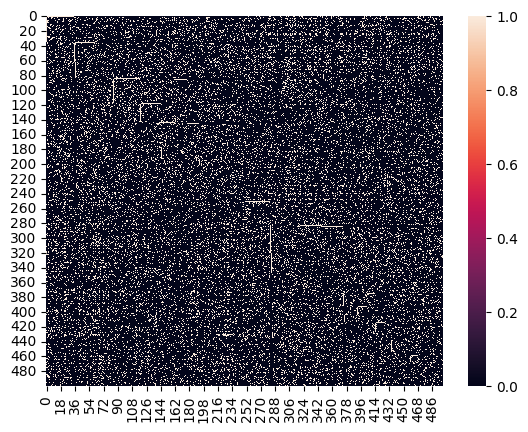

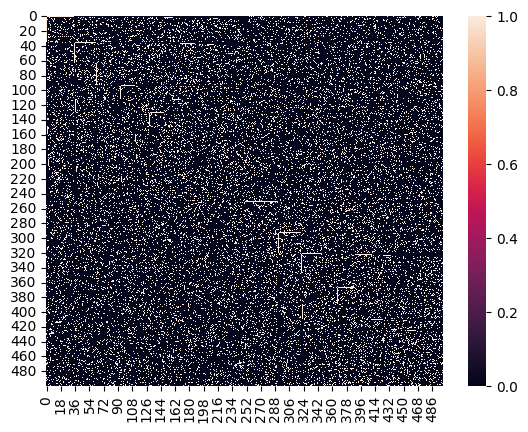

In [2]:
import seaborn as sns
plt.figure()
sns.heatmap(nx.to_numpy_array(modified_G))
plt.figure()
sns.heatmap(nx.to_numpy_array(original_G))

In [3]:
def measure_connectivity(C, cluster_sizes):
    """
    Функция для вычисления фактических долей внутрикластерных (p_in_measured)
    и межкластерных (p_out_measured) связей по итоговой матрице C.
    """
    n_neurons = C.shape[0]
    labels = np.empty(n_neurons, dtype=int)
    start = 0
    for idx, size in enumerate(cluster_sizes):
        labels[start:start + size] = idx
        start += size

    intra_possible = 0
    intra_actual = 0
    inter_possible = 0
    inter_actual = 0

    # Перебор пар нейронов (i < j)
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            if labels[i] == labels[j]:
                intra_possible += 1
                if C[i, j]:
                    intra_actual += 1
            else:
                inter_possible += 1
                if C[i, j]:
                    inter_actual += 1
    print("intra_possible", intra_possible)
    print("intra_actual", intra_actual)
    print("inter_possible", inter_possible)
    print("inter_actual", inter_actual)
    p_in_measured = intra_actual / intra_possible if intra_possible > 0 else 0
    p_out_measured = inter_actual / inter_possible if inter_possible > 0 else 0
    return p_in_measured, p_out_measured

C_total_matrix = nx.to_numpy_array(modified_G)
p_in_measured, p_out_measured = measure_connectivity(C_total_matrix, cluster_sizes)
print(f"Фактическая p_in (доля связей внутри кластера): {p_in_measured:.3f}")
print(f"Фактическая p_out (доля связей между кластерами): {p_out_measured:.3f}")

intra_possible 62250
intra_actual 9390
inter_possible 62500
inter_actual 8933
Фактическая p_in (доля связей внутри кластера): 0.151
Фактическая p_out (доля связей между кластерами): 0.143
